**Importing Necessary Libraries**


In [15]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

**Reading and Visualizing the Dataset**

In [28]:
import os
import pandas as pd

# Directory containing the images
base_dir = 'ad'

# Initialize lists to store image paths and their corresponding labels
images = []
labels = []

# Iterate over each category folder
for label in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label)
    
    # Ensure it's a directory and not a file
    if os.path.isdir(label_dir):
        # Iterate over each image in the folder
        for image_filename in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_filename)
            images.append(image_path)
            labels.append(label)

# Create a DataFrame with the image paths and corresponding labels
df = pd.DataFrame({'image': images, 'label': labels})

# Display the DataFrame
df

image         label
0    ad/MildDemented/mildDem692.jpg  MildDemented
1    ad/MildDemented/mildDem666.jpg  MildDemented
2    ad/MildDemented/mildDem653.jpg  MildDemented
3    ad/MildDemented/mildDem660.jpg  MildDemented
4    ad/MildDemented/mildDem682.jpg  MildDemented
..                              ...           ...
251   ad/NonDemented/nonDem2536.jpg   NonDemented
252   ad/NonDemented/nonDem2534.jpg   NonDemented
253   ad/NonDemented/nonDem2521.jpg   NonDemented
254   ad/NonDemented/nonDem2496.jpg   NonDemented
255   ad/NonDemented/nonDem2533.jpg   NonDemented

[256 rows x 2 columns]

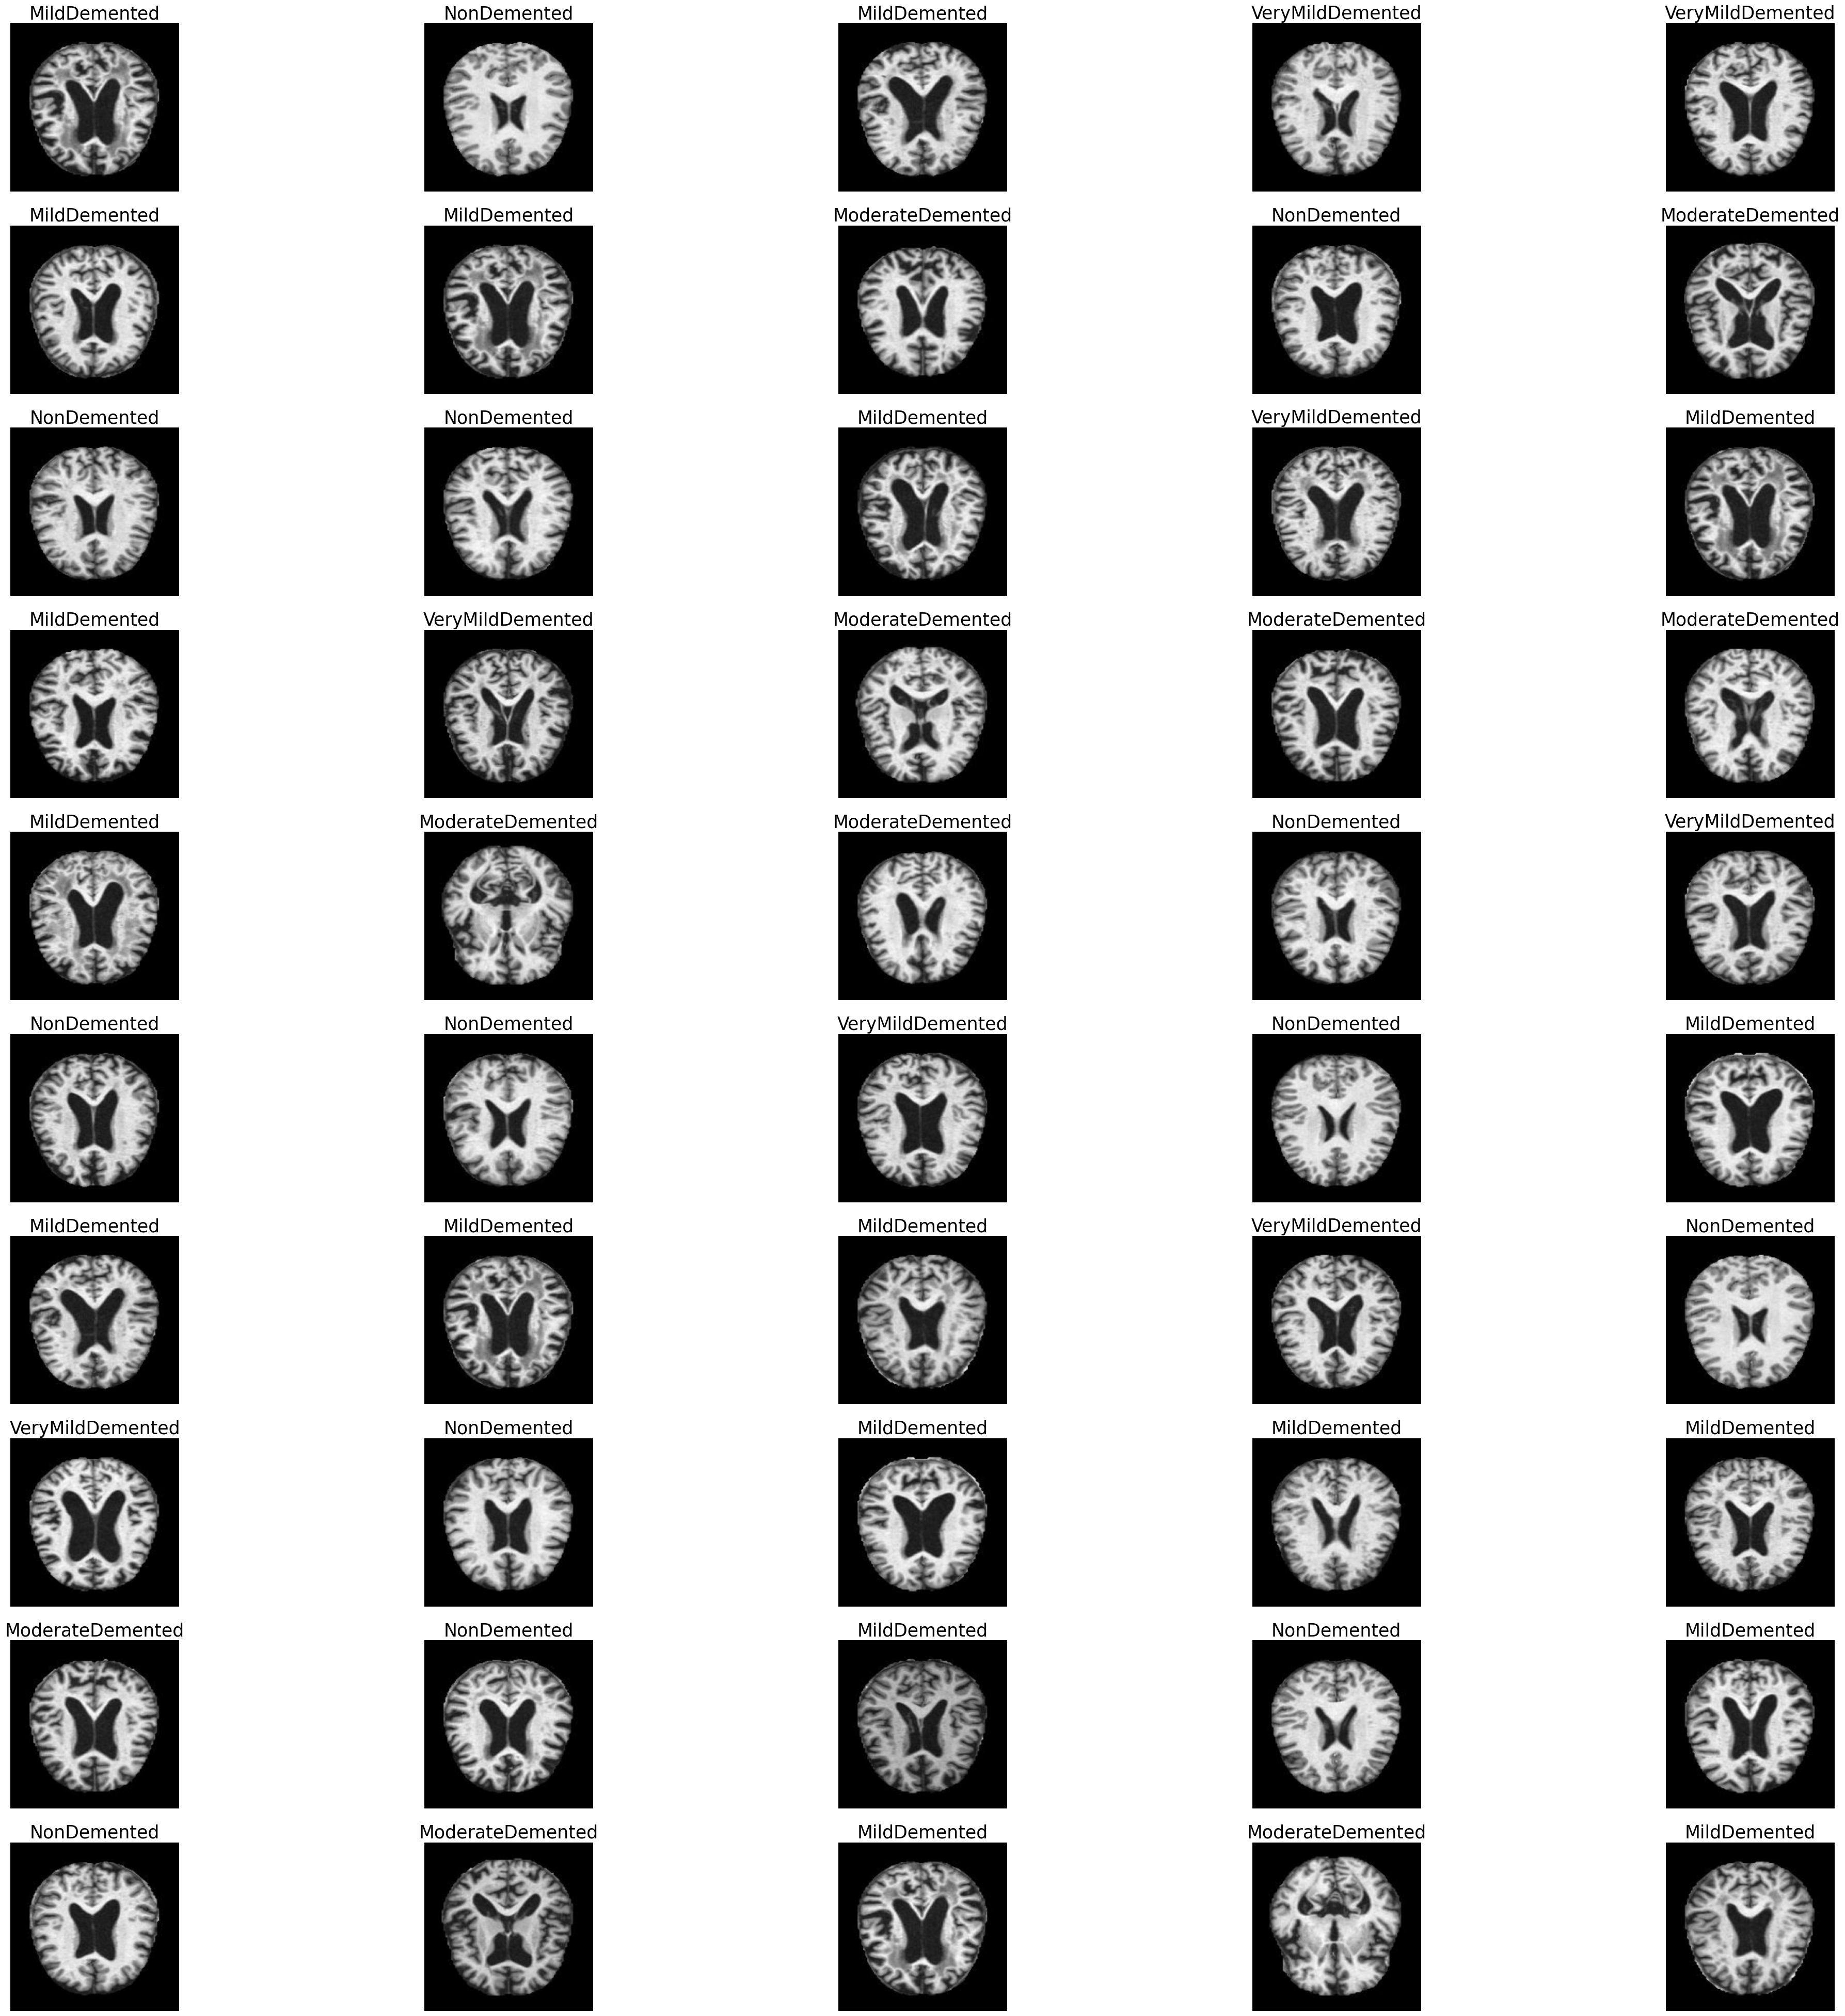

In [18]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

**Data Splitting for Training, Validation, and Testing**

In [30]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 256 validated image filenames belonging to 4 classes.


In [31]:
train_data, train_labels = train_data_gen.next()

In [32]:
class_num=list(train_data_gen.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [34]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(256, 176, 176, 3) (256, 4)


/tmp/ipykernel_13030/1034950569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels,palette='Set1')


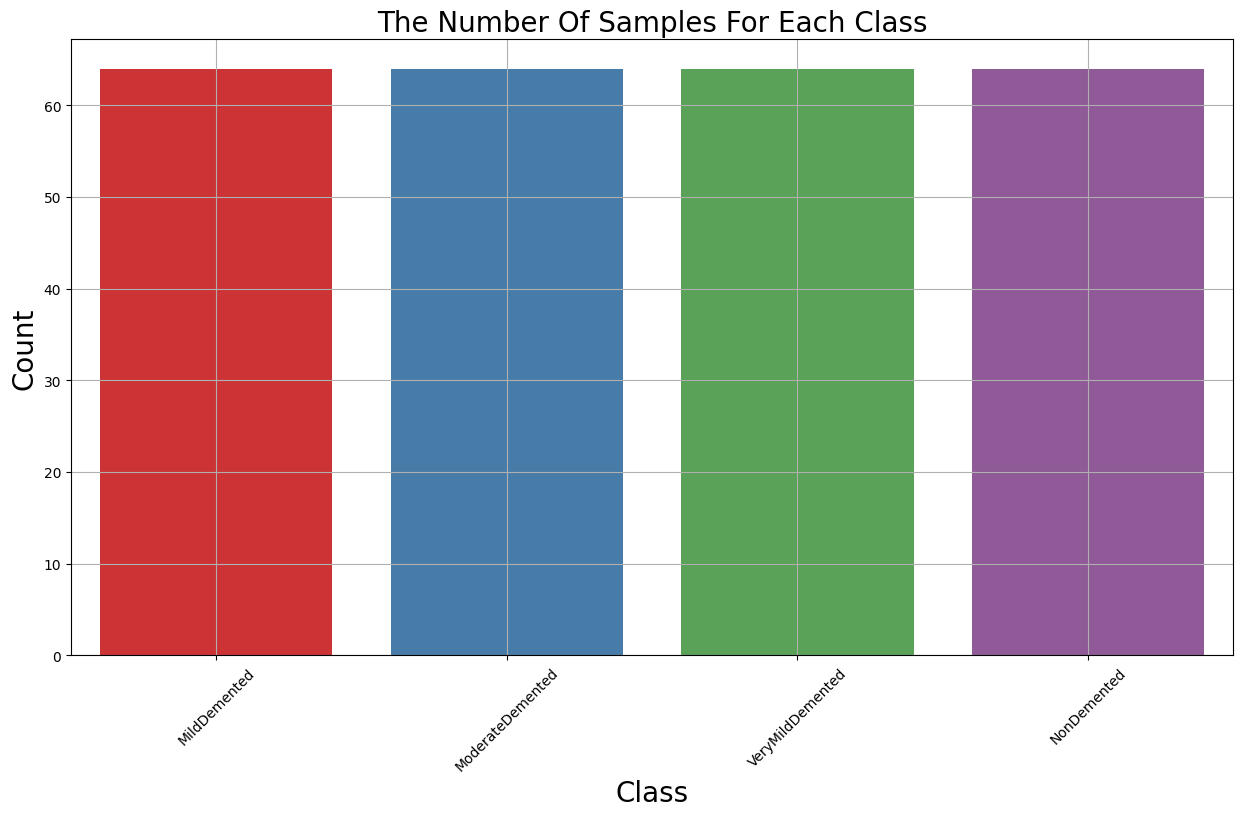

In [35]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [36]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (179, 176, 176, 3)
X_test shape is  (39, 176, 176, 3)
X_val shape is  (38, 176, 176, 3)
y_train shape is  (179, 4)
y_test shape is  (39, 4)
y_val shape is  (38, 4)


In [37]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 88, 88, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 44, 44, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 128)       

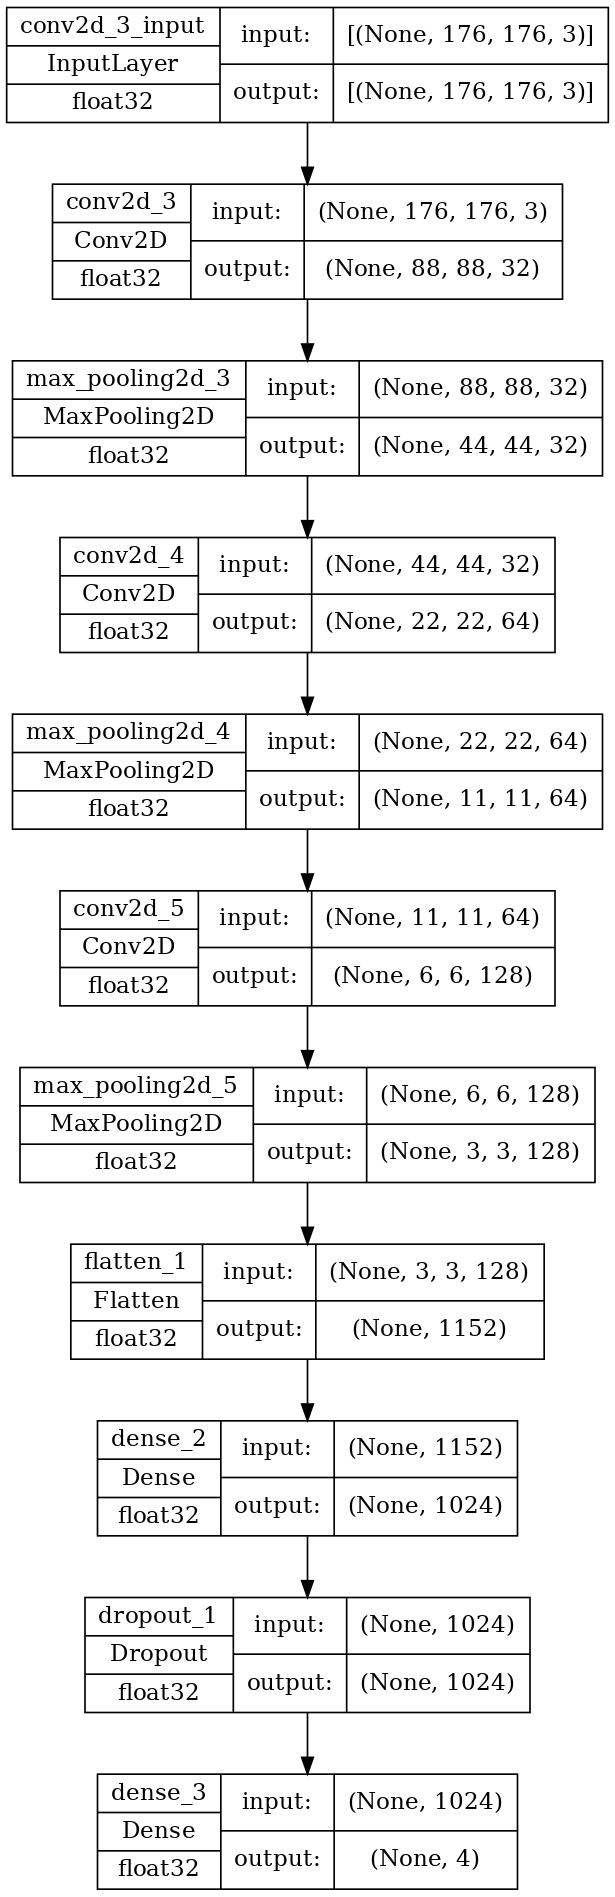

In [38]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [39]:
checkpoint_cb =ModelCheckpoint("CNN_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
6/6 [==============================] - 4s 533ms/step - loss: 1.3941 - accuracy: 0.2402 - val_loss: 1.3740 - val_accuracy: 0.2368
Epoch 2/50
6/6 [==============================] - 3s 453ms/step - loss: 1.3740 - accuracy: 0.2737 - val_loss: 1.3549 - val_accuracy: 0.4211
Epoch 3/50
6/6 [==============================] - 3s 447ms/step - loss: 1.3456 - accuracy: 0.4022 - val_loss: 1.2804 - val_accuracy: 0.5526
Epoch 4/50
6/6 [==============================] - 2s 414ms/step - loss: 1.2415 - accuracy: 0.5251 - val_loss: 1.1121 - val_accuracy: 0.5526
Epoch 5/50
6/6 [==============================] - 3s 450ms/step - loss: 1.0886 - accuracy: 0.5698 - val_loss: 0.9596 - val_accuracy: 0.5526
Epoch 6/50
6/6 [==============================] - 3s 459ms/step - loss: 0.8947 - accuracy: 0.6592 - val_loss: 0.8274 - val_accuracy: 0.6053
Epoch 7/50
6/6 [==============================] - 3s 462ms/step - loss: 0.7506 - accuracy: 0.6872 - val_loss: 0.7633 - val_accuracy: 0.6316
Epoch 8/50
6/6 [====

In [40]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0   1.394121  0.240223  1.373963      0.236842
1   1.373951  0.273743  1.354942      0.421053
2   1.345624  0.402235  1.280439      0.552632
3   1.241503  0.525140  1.112050      0.552632
4   1.088588  0.569832  0.959617      0.552632
5   0.894703  0.659218  0.827427      0.605263
6   0.750560  0.687151  0.763256      0.631579
7   0.629666  0.743017  0.859237      0.605263
8   0.626480  0.720670  0.696025      0.710526
9   0.520393  0.776536  0.654306      0.684211
10  0.425823  0.826816  0.619064      0.684211
11  0.355564  0.882682  0.567077      0.710526
12  0.274183  0.893855  0.642820      0.736842
13  0.241476  0.921788  0.639797      0.736842
14  0.231440  0.938547  0.568463      0.736842
15  0.190998  0.938547  0.634519      0.710526
16  0.143834  0.932961  0.597213      0.789474
17  0.090880  0.983240  0.692829      0.763158
18  0.061449  0.994413  0.656692      0.763158
19  0.063783  0.994413  0.683928      0.710526
20  0.044896  0.994413  0.790025      0.736842
21  0.029715  0.994413  0.749669      0.763158

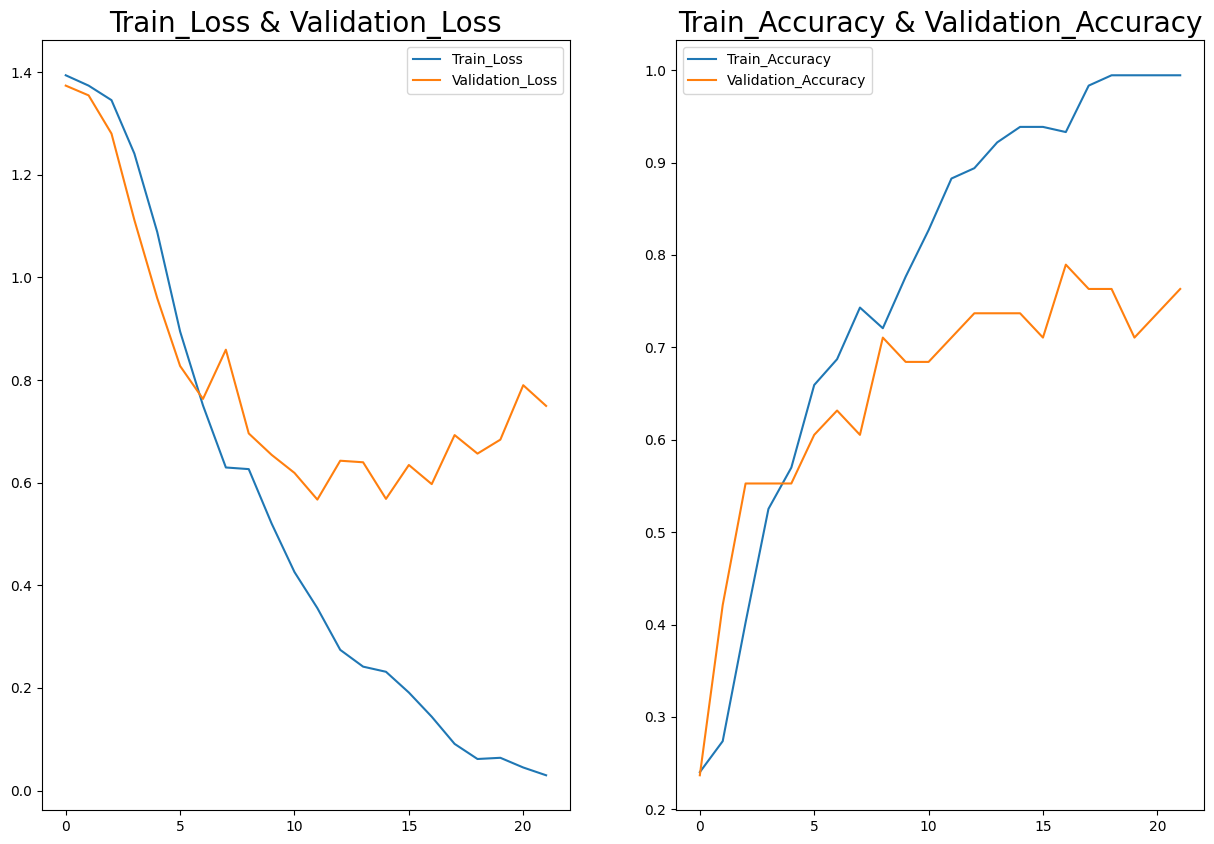

In [41]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [42]:
score, acc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

2/2 [==============================] - 0s 30ms/step - loss: 0.5450 - accuracy: 0.7436
Test Loss = 0.5449554920196533
Test Accuracy = 0.7435897588729858


In [43]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)
df = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
df

2/2 [==============================] - 0s 35ms/step


Actual  Prediction
0        2           0
1        2           2
2        0           2
3        3           0
4        3           3
5        0           2
6        0           3
7        1           1
8        0           3
9        2           2
10       0           0
11       2           2
12       2           2
13       1           1
14       2           2
15       2           2
16       2           2
17       1           1
18       1           1
19       0           0
20       1           1
21       1           1
22       0           0
23       0           0
24       3           0
25       0           0
26       1           1
27       1           1
28       1           1
29       2           2
30       3           0
31       3           3
32       2           2
33       3           3
34       3           3
35       3           3
36       1           1
37       3           0
38       0           3

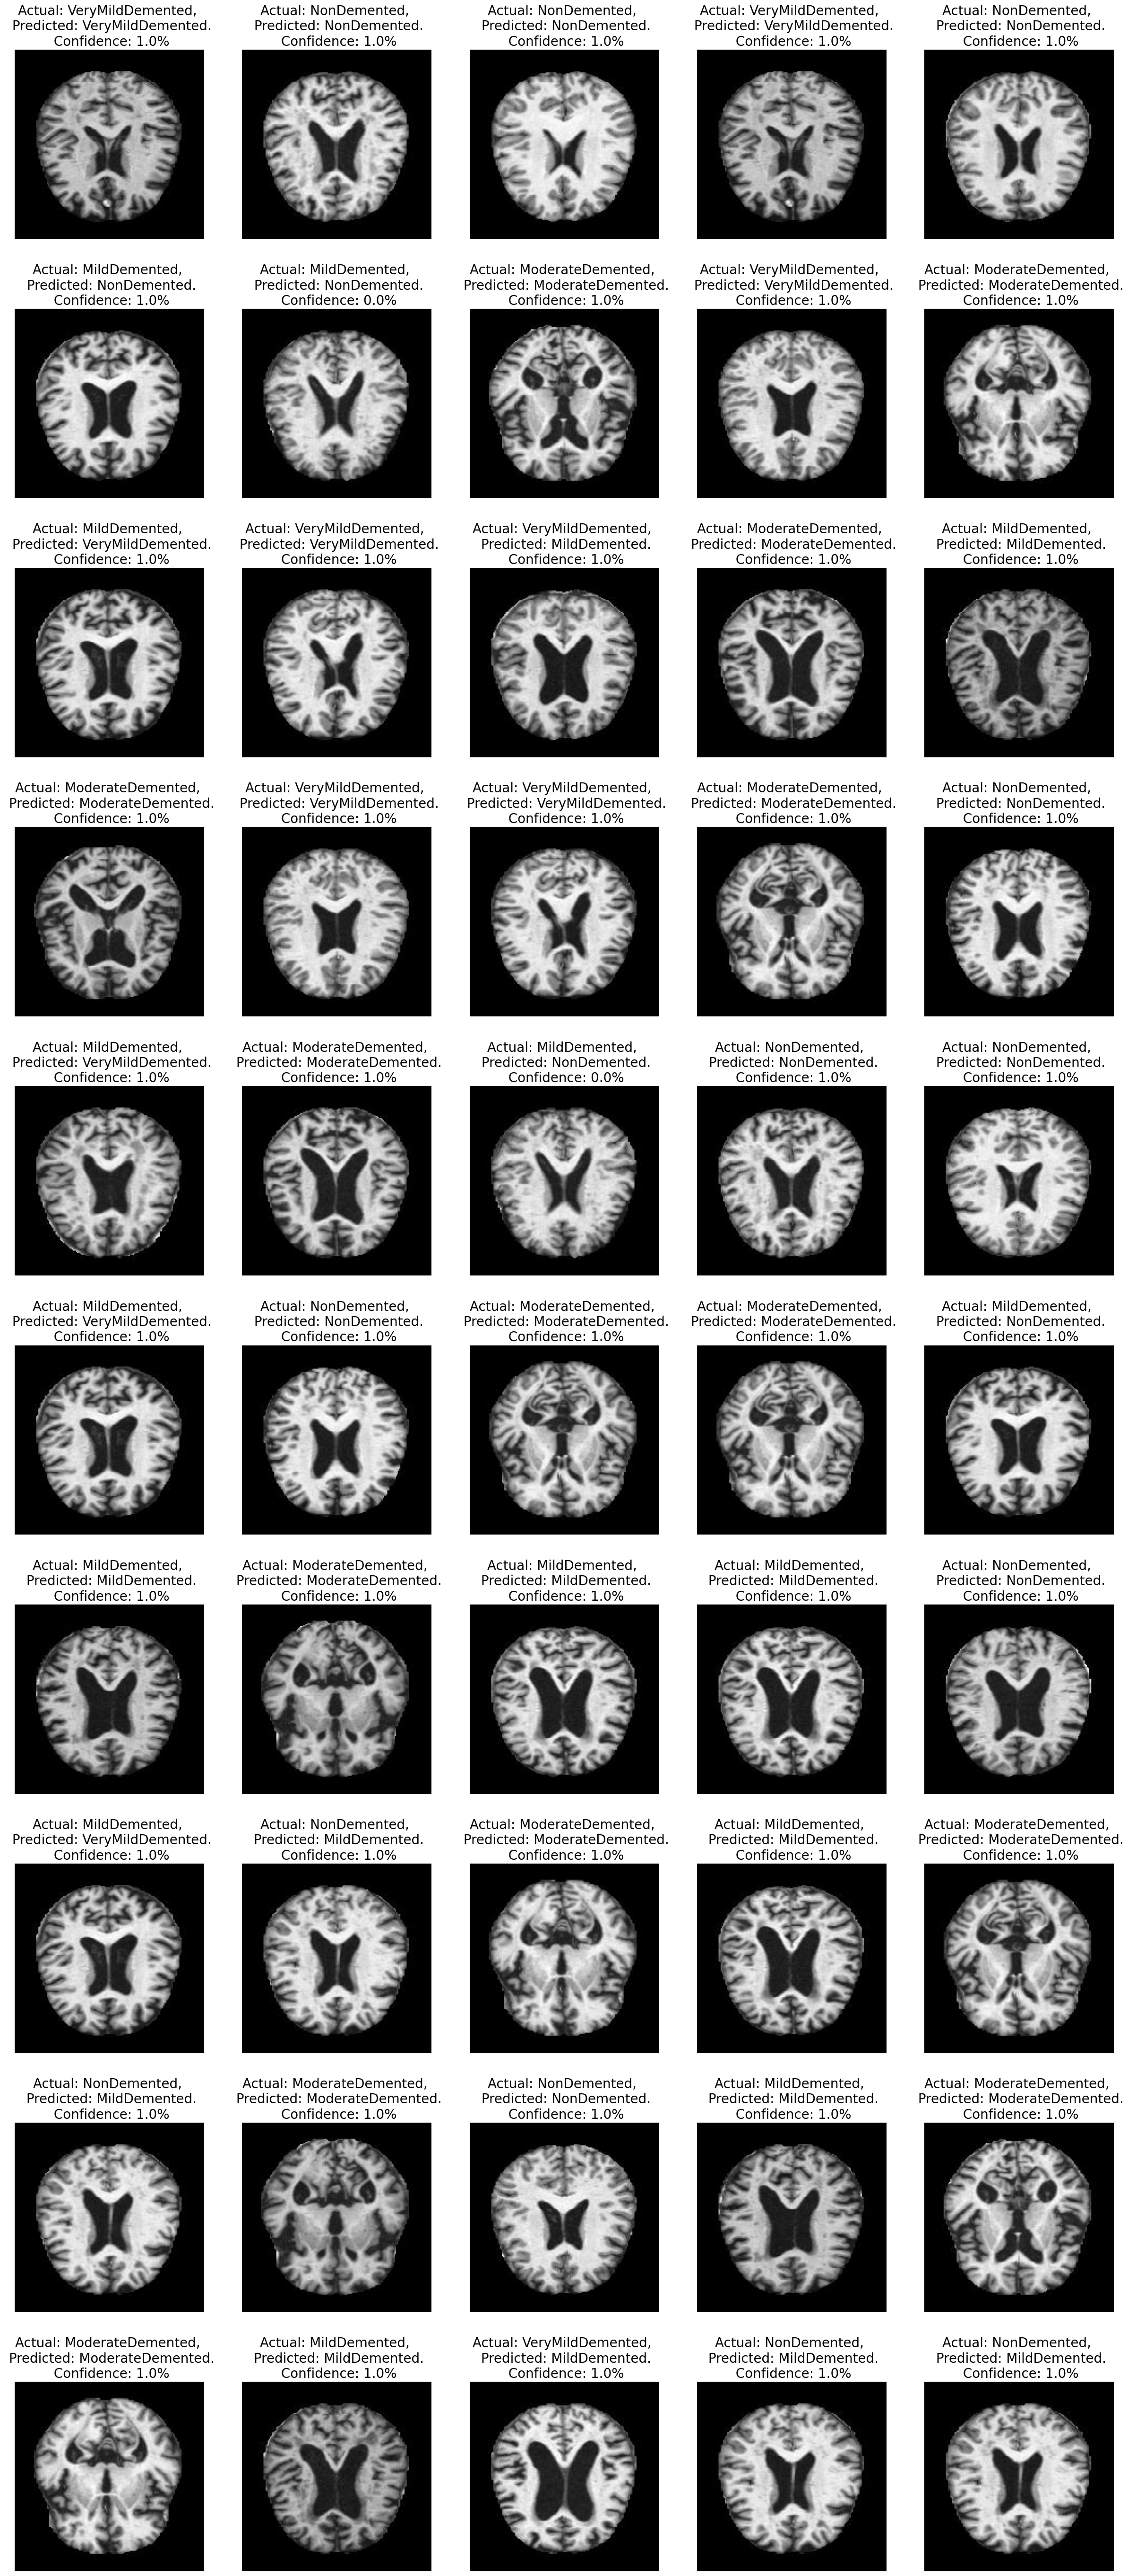

In [44]:
plt.figure(figsize=(30,70))
for n,i in enumerate(np.random.randint(0,len(X_test),50)):
    plt.subplot(10,5,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(f"Actual: {class_num[y_test_[i]]}, \n Predicted: {class_num[y_pred[i]]}.\n Confidence: {round(predictions[i][np.argmax(predictions[i])],0)}%",fontsize=20)

array([[ 5,  0,  2,  3],
       [ 0, 10,  0,  0],
       [ 1,  0,  9,  0],
       [ 4,  0,  0,  5]])

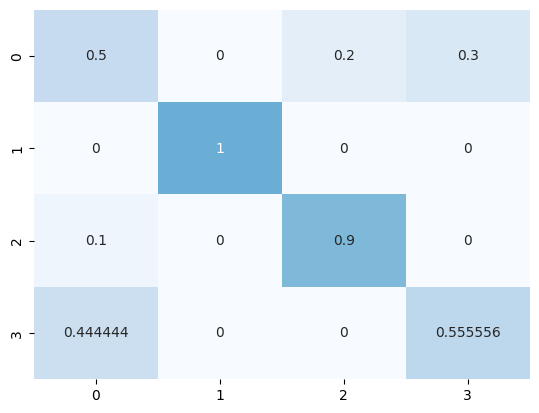

In [45]:
CM = confusion_matrix(y_test_,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [46]:
ClassificationReport = classification_report(y_test_,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       1.00      1.00      1.00        10
           2       0.82      0.90      0.86        10
           3       0.62      0.56      0.59         9

    accuracy                           0.74        39
   macro avg       0.74      0.74      0.74        39
weighted avg       0.74      0.74      0.74        39

